# Stroke analysis script

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as st
import os
import pickle

parcellation = 'Sch240'
n_connectomes = '20'
behaviour_list = ['APM','NART_IQ','Q1_TotalWords','Q6_TotalCorrect','CoC_abs_rev']
normalise_behav = True
reverse_behav = True
CCApermutations = 1000
MCA_components = 5
CCA_components = 5
iterations = 100

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Load data

In [3]:
behav_df, CM, NIFTI = st.load_data(parcellation=parcellation,
                         n_connectomes=n_connectomes,
                         behaviour_list=behaviour_list)

MNIcoords, networks, network_labels = st.get_atlas_info(parcellation=parcellation)

/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
136it [00:06, 21.11it/s]
80it [00:14,  5.51it/s]


### Behaviour plot

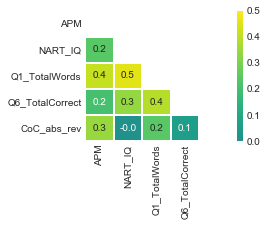

In [31]:
labels = behaviour_list
data = behav_df[behaviour_list].values
st.plotting_tools.behav_heatmap(data,labels)

### Lesion distribution plots

/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


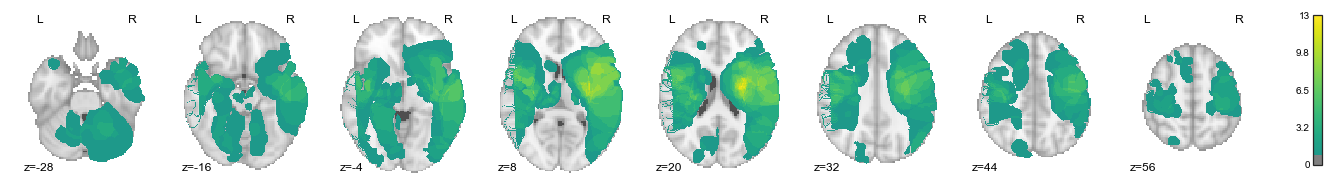

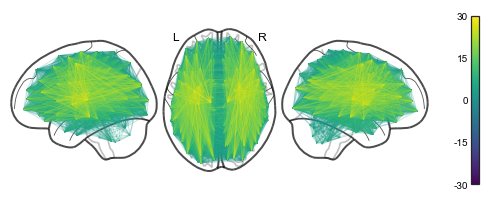

In [5]:
st.plotting_tools.lesion_dist_nii(NIFTI) # consider loading in the original nifti rather than resized for better image
st.plotting_tools.lesion_dist_cm(CM['Diff'],MNIcoords=MNIcoords,vmin=-30)

### Demographics

In [41]:
behav_df.columns

Index(['ID', 'Order', 'Gender', 'Age', 'Age_Groups', 'Population_Type',
       'Chronicity', 'Education', 'NART_Errors', 'NART_IQ', 'APM', 'VOSP',
       'Left_Hemisphere', 'Right_Hemisphere', 'Posterior', 'Lesion_Combined',
       'Lesion_LR', 'Q1_ResponseTime', 'Q1_TotalWords', 'Q1_Fluency',
       'Q1_Prosody', 'Q1_Errors', 'Q2_OralApraxia', 'Q3_SentenceRepetition',
       'Q4_Naming', 'Q4_Comprehension', 'Comp_Category', 'Q4_Repetition',
       'Q5_ActionNaming', 'Q5_PastTense', 'Q6_TotalCorrect', 'Q6_First15',
       'Q6_Last45', 'Q6_Error_Perseverence', 'Q6_Error_Rulebreak',
       'Q6_MinuteRatio', 'Q6_NewRatio', 'Q7_TotalCorrect',
       'Q7_Error_Preseverence', 'Q7_Error_Rulebreak', 'Q7_MinuteRatio',
       'Q8_TotalScore1', 'Q8_HC_Score', 'Q8_LC_Score', 'Q8_HC_ResponseTime',
       'Q8_LC_ResponseTime', 'Q9_TotalScore1', 'Q9_HF_Score', 'Q9_PN_Score',
       'Q9_HF_ResponseTime', 'Q9_PN_ResponseTime', 'Q10_Memory',
       'Percentage_BDALS_Complete', 'ZQ1_TotalWords', 'ZQ2_Ora

In [52]:
for meas in ['Age','Education','Chronicity','NART_IQ','APM','Q1_TotalWords','Q6_TotalCorrect','CoC_abs_rev']:
    print(meas)
    print('\tMean =',np.round(np.mean(behav_df[meas]),2))
    #print('\tMedian =',np.round(np.median(behav_df[meas]),2))
    print('\tStd =',np.round(np.std(behav_df[meas]),2))
    print('\tmin =',np.round(np.min(behav_df[meas]),2))
    print('\tmax =',np.round(np.max(behav_df[meas]),2))

Age
	Mean = 59.5
	Std = 16.4
	min = 24
	max = 91
Education
	Mean = 11.89
	Std = 2.83
	min = 7
	max = 19
Chronicity
	Mean = 3.3
	Std = 4.52
	min = 0.0
	max = 28.0
NART_IQ
	Mean = 98.01
	Std = 10.13
	min = 77.0
	max = 120.0
APM
	Mean = 5.32
	Std = 2.94
	min = 0.0
	max = 11.0
Q1_TotalWords
	Mean = 68.78
	Std = 38.91
	min = 7
	max = 199
Q6_TotalCorrect
	Mean = 11.04
	Std = 6.06
	min = 0.0
	max = 26.0
CoC_abs_rev
	Mean = -0.05
	Std = 0.1
	min = -0.64
	max = 0.0


# Connectivity based analyses

## Multiple correspondance analysis (MCA)
- 'X' is the connectivity data variable
- 'mca.ind_weights' is the data when reduced to 10 components

In [7]:
# reshape connectivity data
n_subs = np.shape(CM['Diff'])[2]
n_nodes = np.shape(CM['Diff'])[0]
n_edges = np.int((n_nodes*(n_nodes-1))/2)
print('Subjects=',n_subs,', nodes=',n_nodes,', edges=',n_edges)

X_full = np.zeros((n_subs,n_edges))
index_upper = np.triu_indices(n_nodes, k=1)
for subj in range(n_subs):
    data = CM['Diff'][:,:,subj].copy()
    X_full[subj,:] = data[index_upper].copy()

# binarize edges
X_full = X_full > 0

# remove non informative features
keep_features = np.sum(X_full,axis=0)>3
X = X_full[:,keep_features]
print('Edges included=',np.sum(keep_features))
print('Calculating MCA...')
mca = st.do_MCA(X,n_components=MCA_components)
mca.keep_features = keep_features
print('Finished MCA!')

# put MCA edges into connectivity matrix space
mca.edge_scores_mat = np.zeros((n_nodes,n_nodes,MCA_components))
for i in range(MCA_components):
    data = np.zeros((len(mca.keep_features)))
    data[mca.keep_features] = mca.edge_scores[:,i]
    data_mat = np.zeros((n_nodes,n_nodes))
    data_mat[index_upper] = data
    mca.edge_scores_mat[:,:,i] = data_mat
print('Eigenvalues=',np.round(mca.eigenvalues_,4))
print('Sum of eigenvalues=',np.round(np.sum(mca.eigenvalues_),4))

Subjects= 80 , nodes= 240 , edges= 28680
Edges included= 7779
Calculating MCA...
Finished MCA!
Eigenvalues= [0.239  0.1043 0.0564 0.0497 0.0355]
Sum of eigenvalues= 0.4849


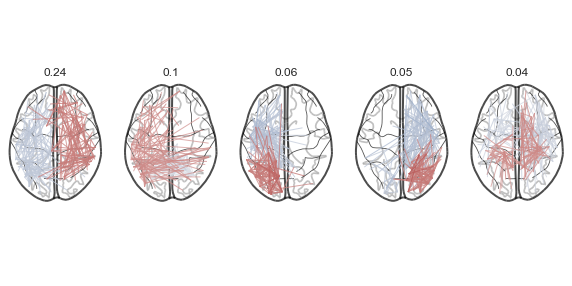

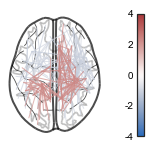

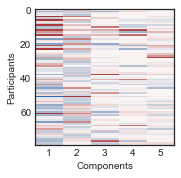

In [8]:
# MCA plots
st.MCA_cm_plots(mca,MCA_components,MNIcoords=MNIcoords,num_edge=200,title=None)

## Canonical correlation analysis (CCA)

In [9]:
y = behav_df[behaviour_list].values

if normalise_behav:
    y = st.vanderWaerden_transform(y)
if reverse_behav:
    y = y*-1

# do cca
cca,p_adj = st.do_cca(mca.ind_scores,y,X,n_components=CCA_components,permutations=CCApermutations)
print('Raw LCr values=',np.round(cca.mode_r,2))
print('Padj for modes=',p_adj)

# put CCA weights back in original space
cca.x_weights_mat = np.zeros((n_nodes,n_nodes,CCA_components))
for i in range(2):
    data = np.zeros((len(keep_features)))
    data[keep_features] = cca.x_score_correlation[:,i]
    data_mat = np.zeros((n_nodes,n_nodes))
    data_mat[index_upper] = data
    cca.x_weights_mat[:,:,i] = data_mat

100%|██████████| 1000/1000 [00:04<00:00, 242.75it/s]

Raw LCr values= [0.7  0.45 0.27 0.12 0.05]
Padj for modes= [0.0, 0.195, 0.995, 1.0, 1.0]


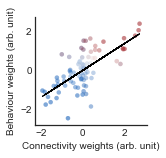

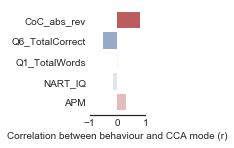

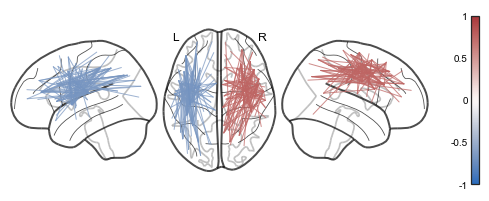

In [10]:
# cca plots (mode 1)
st.CCA_UV_plot(cca)
st.CCA_behav_plot(cca,labels=behaviour_list)
st.CCA_cm_brain_plot(cca,MNIcoords,num_edge=200,mode=0)

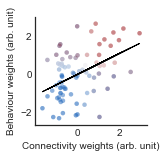

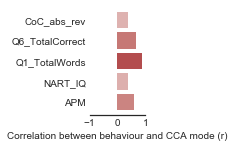

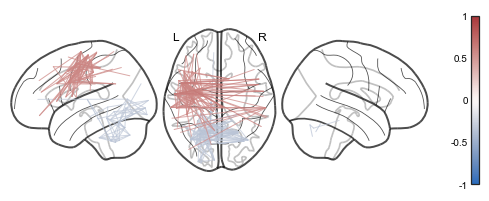

In [11]:
# cca plots (mode 2)
st.CCA_UV_plot(cca,mode=1)
st.CCA_behav_plot(cca,labels=behaviour_list,mode=1)
st.CCA_cm_brain_plot(cca,MNIcoords,num_edge=200,mode=1)

## Network affiliation analysis

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


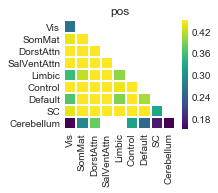

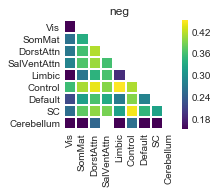

In [12]:
MNIcoords, networks, network_labels = st.get_atlas_info(parcellation=parcellation)
network_mean = st.network_affilation_cm(cca,CCA_components,networks)
st.network_plot(network_mean,network_labels)

## Cross validated prediction

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cross_decomposition import CCA
from tqdm import tqdm

def cv_cca(X,y,iterations=1000,num_cvs=10):
    cv = KFold(n_splits=num_cvs,shuffle=True)
    y_pred = np.zeros((np.shape(y)))

    r = np.zeros((iterations,np.shape(y)[1]))
    MAE = r.copy()
    Rsqr = r.copy()
    for j in tqdm(range(iterations)):
        for train_index, test_index in cv.split(X):
            #organise the data into training and testing sets
            X_train = X[train_index,:]
            y_train = y[train_index,:]
            X_test  = X[test_index,:]

            # do cca
            cv_cca = CCA(n_components=1)
            cv_cca.fit(X_train,y_train)

            # predict left out values
            y_pred[test_index,:] = cv_cca.predict(X_test)

            # save predictions for this iteration
            for i in range(np.shape(y)[1]):
                r[j,i] = np.corrcoef(y[:,i],y_pred[:,i])[0,1]
                MAE[j,i] = mean_absolute_error(y[:,i],y_pred[:,i])
                Rsqr[j,i] = r2_score(y[:,i],y_pred[:,i])
    return r,MAE,Rsqr

In [14]:
cv_conn_r,cv_conn_MAE,cv_conn_Rsqr = cv_cca(mca.ind_scores,y,iterations)

100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


# Exploratory interhemispheric connectivity analysis
- Only include interhemispheric connections

In [15]:
# # generate an interhemispheric index array
# # reshape connectivity data
# n_subs = np.shape(CM['Diff'])[2]
# n_nodes = np.shape(CM['Diff'])[0]
# n_edges = np.int((n_nodes*(n_nodes-1))/2)
# interhemispheric_index = np.zeros((n_nodes,n_nodes))

# for i in range(len(MNIcoords)):
#     roi = MNIcoords[i,0]
#     if roi < 0:
#         interhemispheric_index[i,MNIcoords[:,0] > 0] = np.int(1)
#     if roi > 0:
#         interhemispheric_index[i,MNIcoords[:,0] < 0] = np.int(1)

# plt.figure(figsize=(2,2))
# plt.imshow(interhemispheric_index,aspect='auto')
# plt.show()
# interhemispheric_index = np.where(interhemispheric_index==0)

## MCA

In [16]:
# # reshape connectivity data
# X_full = np.zeros((n_subs,n_edges))
# index_upper = np.triu_indices(n_nodes, k=1)
# for subj in range(n_subs):
#     data = CM['Diff'][:,:,subj].copy()
#     data[interhemispheric_index] = 0
#     X_full[subj,:] = data[index_upper].copy()

# # binarize edges
# X_full = X_full > 0

# # remove non informative features
# keep_features = np.sum(X_full,axis=0)>0
# X = X_full[:,keep_features]

# print('Calculating MCA...')
# mca = st.do_MCA(X,n_components=MCA_components)
# print('Finished MCA!')

# # put MCA edges into connectivity matrix space
# mca.edge_scores_mat = np.zeros((n_nodes,n_nodes,MCA_components))
# for i in range(MCA_components):
#     data = np.zeros((len(keep_features)))
#     data[keep_features] = mca.edge_scores[:,i]
#     data_mat = np.zeros((n_nodes,n_nodes))
#     data_mat[index_upper] = data
#     mca.edge_scores_mat[:,:,i] = data_mat

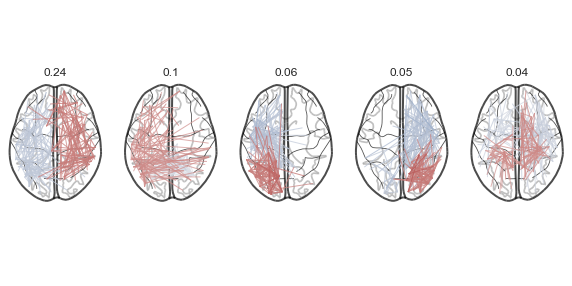

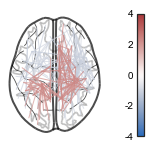

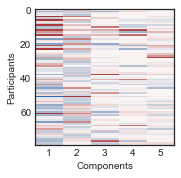

In [17]:
# MCA plots
st.MCA_cm_plots(mca,MCA_components,MNIcoords=MNIcoords,num_edge=200,title=None)

## CCA

In [18]:
# y = behav_df[behaviour_list].values

# if normalise_behav:
#     y = st.vanderWaerden_transform(y)

# # do cca
# cca,p_adj = st.do_cca(mca.ind_scores,y,X,n_components=CCA_components,permutations=CCApermutations)
# print('Raw LCr values=',np.round(cca.mode_r,2))
# print('Pvalues for components=',p_adj)

# # put CCA weights back in original space
# cca.x_weights_mat = np.zeros((n_nodes,n_nodes,CCA_components))
# for i in range(2):
#     data = np.zeros((len(keep_features)))
#     data[keep_features] = cca.x_score_correlation[:,i]
#     data_mat = np.zeros((n_nodes,n_nodes))
#     data_mat[index_upper] = data
#     cca.x_weights_mat[:,:,i] = data_mat

In [19]:
# # cca plots
# st.CCA_UV_plot(cca)
# st.CCA_behav_plot(cca,labels=behaviour_list)
# st.CCA_cm_brain_plot(cca,MNIcoords)

## Network affiliations

In [20]:
# MNIcoords, networks, network_labels = st.get_atlas_info(parcellation=parcellation)
# network_mean = st.network_affilation_cm(cca,CCA_components,networks)
# st.network_plot(network_mean,network_labels)

# Voxel based analyses
Uses a lot of memory! Runs out if voxel lesion inclusion is low when correlating with weights in the CCA...

## MCA

In [21]:
# which voxels to include when thresholding across participants
# ideally '0' but runs quite slow.
voxel_lesion_inclusion = 4

#check if MCA file already exists (very slow to ru)
file = '/Users/luke/Documents/Projects/StrokeNet/Data/MCA/voxel_MCA_results_thresh_'+str(voxel_lesion_inclusion)+'.pkl'
if os.path.isfile(file):
    print('Loading voxelwise MCA data...')
    mca = pickle.load(open(file,'rb'))
else:    
    # reshape connectivity data
    n_subs = np.shape(NIFTI)[3]
    n_voxels = np.int(np.shape(NIFTI)[0]*np.shape(NIFTI)[1]*np.shape(NIFTI)[2])
    print('Subjects=',n_subs,', voxels=',n_voxels)

    X_full = np.zeros((n_subs,n_voxels))
    for subj in range(n_subs):
        data = NIFTI[:,:,:,subj].copy()
        data = np.reshape(data,[n_voxels],order='C')
        X_full[subj,:] = data.copy()

    # binarize edges
    X_full = X_full > 0

    # remove non informative features
    keep_features = np.sum(X_full,axis=0)>voxel_lesion_inclusion
    X = X_full[:,keep_features]
    print('Features included=',np.sum(keep_features))
    print('Calculating MCA...')
    mca = st.do_MCA(X,n_components=MCA_components)
    print('Finished MCA!')

    # reshape data 
    dims = np.shape(NIFTI)
    mca.edge_scores_mat = np.zeros((dims[0],dims[1],dims[2],MCA_components))
    for i in range(MCA_components):
        data = np.zeros((len(keep_features)))
        data[keep_features] = mca.edge_scores[:,i]
        data_mat = np.zeros((dims[0],dims[1],dims[2]))
        data_mat = np.reshape(data,np.shape(data_mat),order='C')
        mca.edge_scores_mat[:,:,:,i] = data_mat
    print('Eigenvalues=',np.round(mca.eigenvalues_,4))
    print('Sum of eigenvalues=',np.round(np.sum(mca.eigenvalues_),4))

    # save data out
    mca.keep_features = keep_features.copy()
    mca.X = X
    pickle.dump(mca,open(file,'wb'))

Loading voxelwise MCA data...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/luke/Documents/Projects/StrokeNet/Data/MCA/voxel_MCA_results_thresh_4.pkl'>
  if __name__ == '__main__':


/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


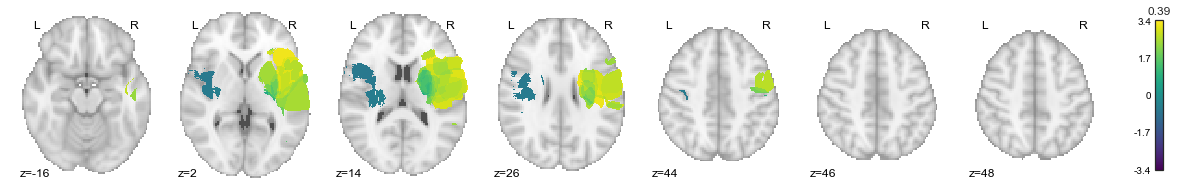

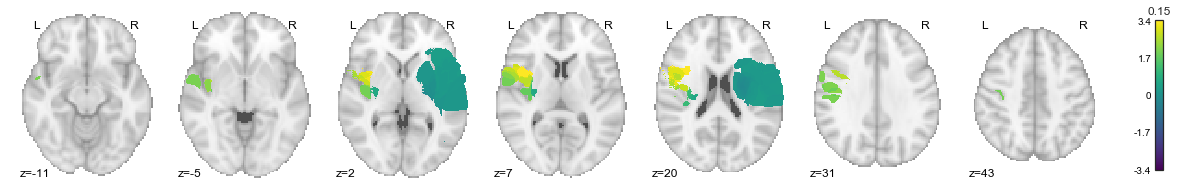

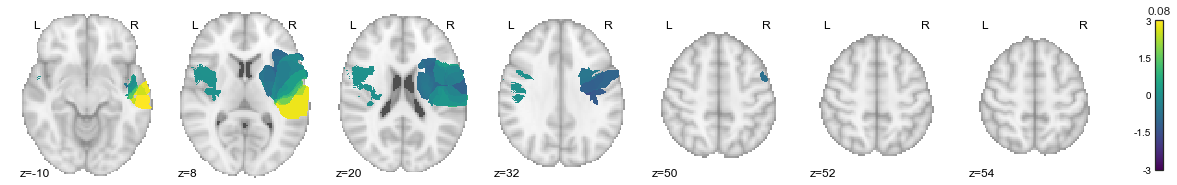

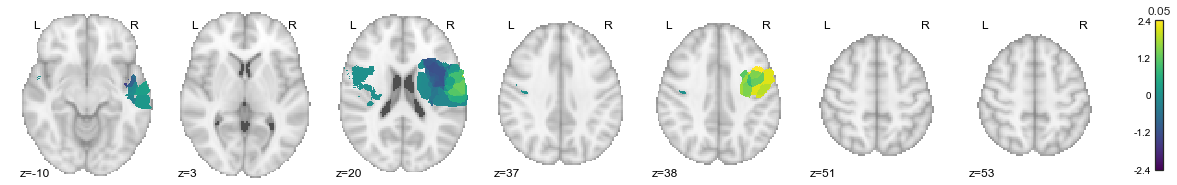

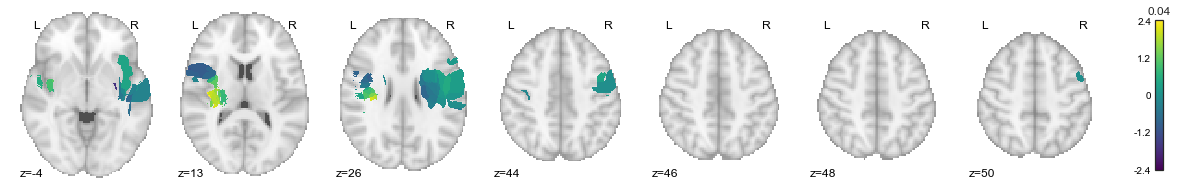

In [22]:
from nilearn import plotting
import nibabel as nib

affine = np.array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

for component in range(MCA_components):
    array_data = mca.edge_scores_mat[:,:,:,component]
    img = nib.Nifti1Image(array_data, affine)
    plotting.plot_stat_map(img,cmap='viridis',display_mode='z',colorbar=True)
    plt.title(np.round(mca.eigenvalues_[component],2))
    plt.show()

## CCA

In [23]:
y = behav_df[behaviour_list].values

if normalise_behav:
    y = st.vanderWaerden_transform(y)
if reverse_behav:
    y = y*-1
    
# do cca
cca,p_adj = st.do_cca(mca.ind_scores,y,mca.X,n_components=CCA_components,permutations=CCApermutations)
print('Raw LCr values=',np.round(cca.mode_r,2))
print('Pvalues for components=',p_adj)

# reshape data 
dims = np.shape(NIFTI)
cca.x_weights_mat = np.zeros((dims[0],dims[1],dims[2],CCA_components))
for i in range(2):
    data = np.zeros((len(mca.keep_features)))
    data[mca.keep_features] = cca.x_score_correlation[:,i]
    data_mat = np.zeros((dims[0],dims[1],dims[2]))
    data_mat = np.reshape(data,np.shape(data_mat),order='C')
    cca.x_weights_mat[:,:,:,i] = data_mat

100%|██████████| 1000/1000 [00:04<00:00, 203.36it/s]


Raw LCr values= [0.69 0.57 0.51 0.41 0.19]
Pvalues for components= [0.0, 0.127, 0.48, 0.976, 1.0]


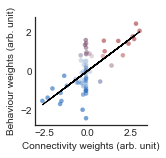

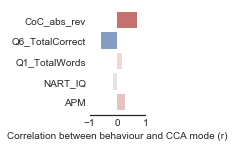

/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


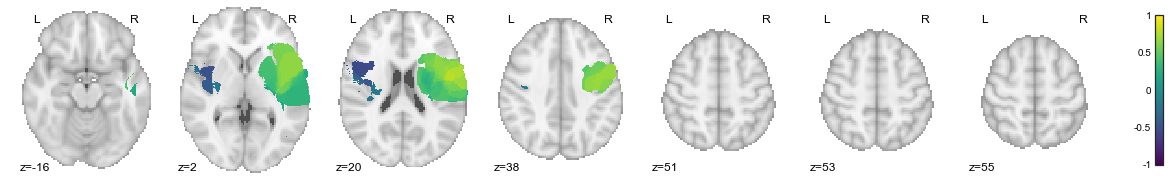

In [24]:
# cca plots
st.CCA_UV_plot(cca)
st.CCA_behav_plot(cca,labels=behaviour_list)
st.CCA_nifti_brain_plot(cca)

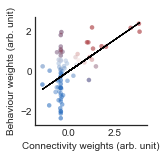

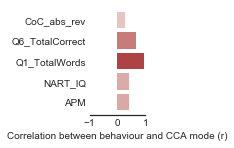

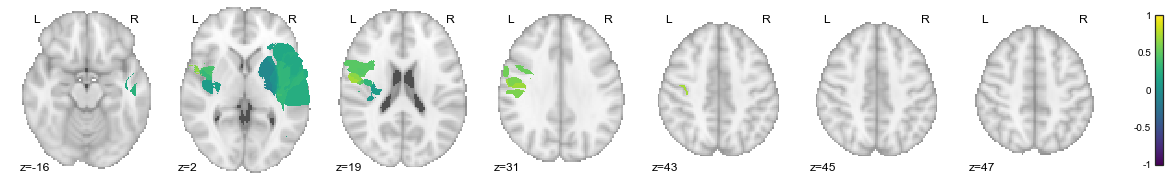

In [25]:
# cca plots
st.CCA_UV_plot(cca,mode=1)
st.CCA_behav_plot(cca,labels=behaviour_list,mode=1)
st.CCA_nifti_brain_plot(cca,mode=1)

In [26]:
cv_vox_r,cv_vox_MAE,cv_vox_Rsqr = cv_cca(mca.ind_scores,y,iterations)

100%|██████████| 100/100 [00:04<00:00, 20.81it/s]


# Model comparison

## Connectivity

Vox r = 0.07809732496938877
Conn r = 0.0853597875988417


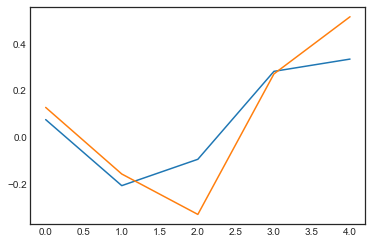

Vox mae = 0.7998695656634763
Conn mae = 0.7628568135919839


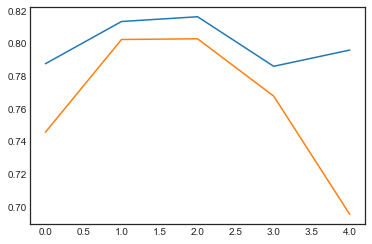

Vox r2 = -0.10691306932116483
Conn r2 = -0.001020241958661871


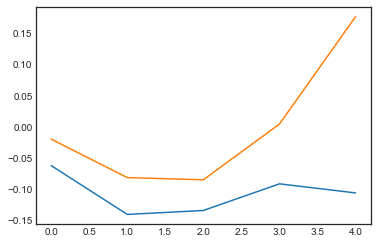

In [27]:
plt.plot(np.vstack((np.mean(cv_vox_r,axis=0),np.mean(cv_conn_r,axis=0))).T)
print('Vox r =',np.mean(cv_vox_r))
print('Conn r =',np.mean(cv_conn_r))
plt.show()
plt.plot(np.vstack((np.mean(cv_vox_MAE,axis=0),np.mean(cv_conn_MAE,axis=0))).T)
print('Vox mae =',np.mean(cv_vox_MAE))
print('Conn mae =',np.mean(cv_conn_MAE))
plt.show()
plt.plot(np.vstack((np.mean(cv_vox_Rsqr,axis=0),np.mean(cv_conn_Rsqr,axis=0))).T)
print('Vox r2 =',np.mean(cv_vox_Rsqr))
print('Conn r2 =',np.mean(cv_conn_Rsqr))
plt.show()


In [28]:
## Comparison
from scipy import stats

In [29]:
stats.ttest_ind(cv_vox_MAE[:,2],cv_conn_MAE[:,2])

Ttest_indResult(statistic=5.7245223769067355, pvalue=3.799431896852742e-08)

In [30]:
np.shape(cv_vox_MAE)

(100, 5)